In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
C      = 400e-12  # [F]
tau    = 20e-3    # [s]
Rm     = tau / C  # [Ω]
gL     = 1 / Rm   # [S]
EL     = -70e-3   # [V]
VT0    = -54e-3   # [V]
Vreset = -65e-3   # [V]
I0     = 500e-12  # [A]
tarp   = 5e-3     # [s] refractory period

In [3]:
weights = {'eta': np.array([50,5]), 'gamma': np.array([3])}
taus = {'eta': np.array([0.2,1]), 'gamma': np.array([0.01])}
f = lambda x,weights,taus: np.sum([w*np.exp(-x/tau) for w,tau in zip(weights,taus)])
η = lambda x: f(x,weights['eta'],taus['eta'])
γ = lambda x: f(x,weights['gamma'],taus['gamma'])
H = lambda t,S: np.sum([η(t-tspk) for tspk in S])
G = lambda t,S: np.sum([γ(t-tspk) for tspk in S])
λ = lambda x,σ,λ0: λ0 * np.exp(x/σ)
σ = 1e-3   # [V]
λ0 = 100   # [Hz]

In [10]:
t_spikes = np.array([100, 120, 200]) * 1e-3
dt = 0.1e-3
time = np.r_[0 : 0.5 : dt]
h = np.zeros_like(time)
g = np.zeros_like(time)
j = 0
S = []
for i,t in enumerate(time):
    if j < t_spikes.size and t > t_spikes[j]:
        S.append(t_spikes[j])
        j += 1
    h[i], g[i] = H(t,S), G(t,S)

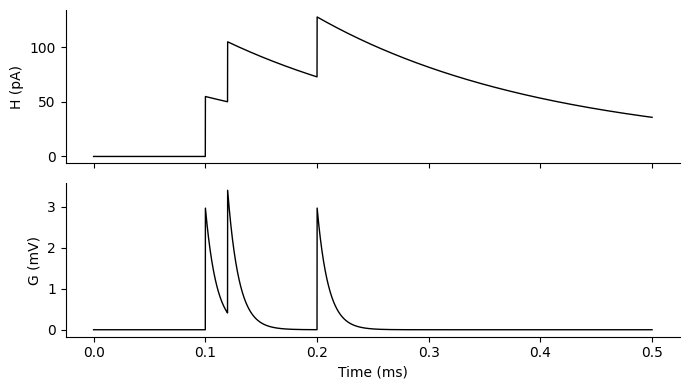

In [13]:
fig,ax = plt.subplots(2, 1, sharex=True, figsize=(7,4))
ax[0].plot(time, h, 'k', lw=1)
ax[1].plot(time, g, 'k', lw=1)
ax[0].set_ylabel('H (pA)')
ax[1].set_ylabel('G (mV)')
ax[1].set_xlabel('Time (ms)')
sns.despine()
fig.tight_layout()

In [16]:
dt = 0.025e-3
tstim = 500e-3
tbefore,tafter = 10e-3, 50e-3
tend = tbefore+tstim+tafter
t = np.r_[0 : tend : dt]
n_samples = t.size

Vm = np.zeros_like(t)
I_adapt = np.zeros_like(t)
VT = np.zeros_like(t)
prob = np.zeros_like(t)

Ie = np.zeros_like(t)
idx, = np.where((t>=tbefore) & (t<=tbefore+tstim))
Ie[idx] = I0

Vm[0] = EL
S = [-1000]

for i in range(n_samples-1):
    I_adapt[i] = H(t[i],S) * 1e-12
    VT[i] = VT0 + G(t[i],S) * 1e-3
    if t[i] - S[-1] < tarp:
        Vm[i+1] = Vm[i]
    else:
        Vm[i+1] = Vm[i] + dt * (gL*(EL-Vm[i]) - I_adapt[i] + Ie[i]) / C
    prob[i] = λ(Vm[i]-VT[i], σ, λ0) * dt
    if np.random.uniform() < prob[i]:
        Vm[i] = 10e-3
        Vm[i+1] = Vreset
        S.append(t[i])
I_adapt[-1] = H(t[-1],S) * 1e-12
VT[-1] = VT0 + G(t[-1],S) * 1e-3
prob[-1] = λ(Vm[-1]-VT[-1], σ, λ0) * dt

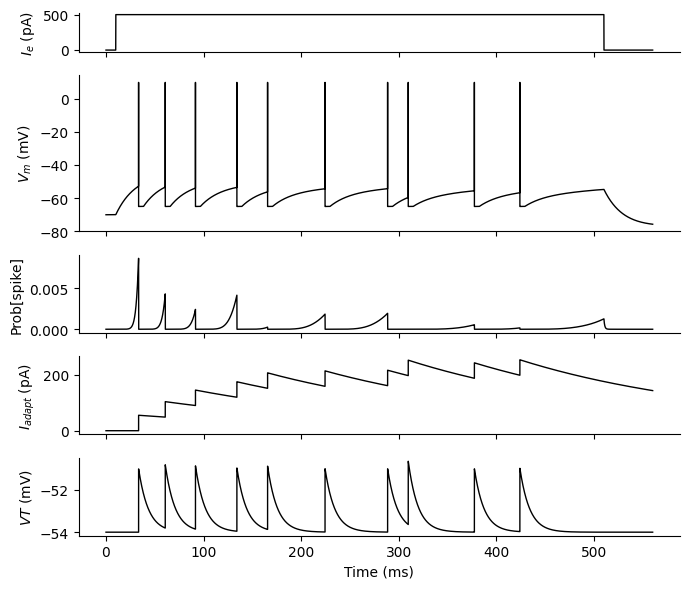

In [17]:
fig,ax = plt.subplots(5, 1, sharex=True, figsize=(7,6), height_ratios=(1,4,2,2,2))
ax[0].plot(t*1e3, Ie*1e12, 'k', lw=1)
ax[1].plot(t*1e3, Vm*1e3, 'k', lw=1)
ax[2].plot(t*1e3, prob, 'k', lw=1)
ax[3].plot(t*1e3, I_adapt*1e12, 'k', lw=1)
ax[4].plot(t*1e3, VT*1e3, 'k', lw=1)
ax[-1].set_xlabel('Time (ms)')
ax[0].set_ylabel(r'$I_e$ (pA)')
ax[1].set_ylabel(r'$V_m$ (mV)')
ax[2].set_ylabel('Prob[spike]')
ax[3].set_ylabel(r'$I_{adapt}$ (pA)')
ax[4].set_ylabel(r'$VT$ (mV)')
sns.despine()
fig.tight_layout()

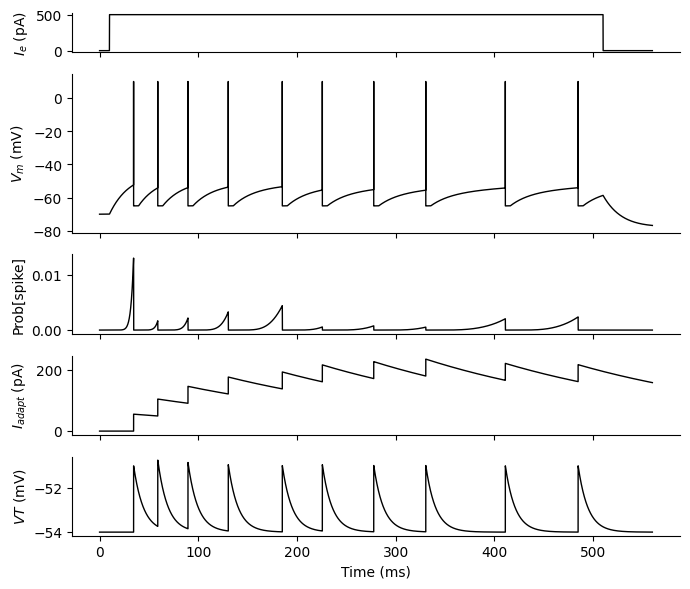

In [15]:
fig,ax = plt.subplots(5, 1, sharex=True, figsize=(7,6), height_ratios=(1,4,2,2,2))
ax[0].plot(t*1e3, Ie*1e12, 'k', lw=1)
ax[1].plot(t*1e3, Vm*1e3, 'k', lw=1)
ax[2].plot(t*1e3, prob, 'k', lw=1)
ax[3].plot(t*1e3, I_adapt*1e12, 'k', lw=1)
ax[4].plot(t*1e3, VT*1e3, 'k', lw=1)
ax[-1].set_xlabel('Time (ms)')
ax[0].set_ylabel(r'$I_e$ (pA)')
ax[1].set_ylabel(r'$V_m$ (mV)')
ax[2].set_ylabel('Prob[spike]')
ax[3].set_ylabel(r'$I_{adapt}$ (pA)')
ax[4].set_ylabel(r'$VT$ (mV)')
sns.despine()
fig.tight_layout()